In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
N_FACE = 70
N_POSE = 0

In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import time
import csv

Reshape Data into Segments and Prepare for Keras (part5 data)

In [0]:
train_path = './drive/My Drive/636/dataset/part8/trainset.csv'
trainset = pd.read_csv(train_path, index_col=0)
test_path = './drive/My Drive/636/dataset/part8/testset.csv'
testset = pd.read_csv(test_path, index_col=0)

In [5]:
print(trainset.shape, testset.shape)

(128711, 159) (22722, 159)


In [0]:
# get number of features
N_FEATURES = (N_FACE + N_POSE) * 2

In [0]:
# slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
def get_slices(df, index_arr, TIME_STEP):
  slices = []
  for i in index_arr:
    if i + 1 < TIME_STEP:
      slice_ = df.values[df.index[0 : i + 1]]
      fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
      slice_ = np.concatenate((slice_, fillzero), axis=0)
      slices.append(slice_)
    else:
      slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

  slices_arr = np.asarray(slices, dtype= np.float32)
  return slices_arr

In [0]:
def create_segments(df, TIME_STEP):
  # get video id
  vids = df.vid.unique()
  segments = []
  # get segment of each video id
  for i in vids:
    # slice every 10 frame as a segment and use the first label as label of segment
    # get all index of an id
    index_arr = df.index[df['vid'] == i]
    # drop the id and label
    df_s = df[df.columns[3:143]]

    if i == vids[0]:
      segments = get_slices(df_s, index_arr, TIME_STEP)
    else:
      # get slices of each person
      segment = get_slices(df_s, index_arr, TIME_STEP)
      # print(i, segment.shape)
      segments = np.concatenate((segments, segment), axis=0)

  return segments

In [0]:
X_train = create_segments(trainset, 10)
X_test = create_segments(testset, 10)

In [0]:
y_train = trainset['label'].to_numpy()
y_test = testset['label'].to_numpy()

In [0]:
idx = np.random.permutation(y_train.shape[0])
X_train, y_train = X_train[idx], y_train[idx]

In [0]:
# draw
import matplotlib.pyplot as plt
def draw(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')

  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Build model

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten, Bidirectional, Conv1D, MaxPooling1D, CuDNNLSTM
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5
INPUT_DIM = 140

In [31]:
!pwd

/content


In [0]:
model_checkpoint = ModelCheckpoint(filepath='./drive/My Drive/636/model/part8/ep{epoch:03d}-acc{acc:.3f}-val_acc{val_acc:.3f}.h5',
                                                   monitor='val_loss',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=False,
                                                   period=1)
# callbacks
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                           verbose=2, mode='min')
# reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
# callbacks_list = [early_stop, model_checkpoint, reduce_lr_on_plateau]
callbacks_list = [early_stop, model_checkpoint]

Model 1

In [0]:
# hyperparameter
def create_model_1():
  model = Sequential()
  model.add(Dense(units = 128, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 128, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 64))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model


In [35]:
# create model
model1 = create_model_1()
history1 = model1.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score1 = model1.evaluate(X_test, y_test, verbose=2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10, 128)           18048     
_________________________________________________________________
cu_dnnlstm_9 (CuDNNLSTM)     (None, 10, 128)           132096    
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 64)                49664     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 199,873
Trainable params: 199,873
Non-trainable params: 0
________________________________________________

In [38]:
print("test loss: ", score1[0], "test acc: ", score1[1])

test loss:  0.6560809667466571 test acc:  0.5818150043487549


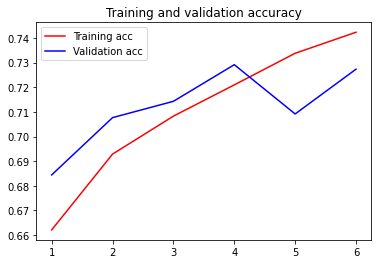

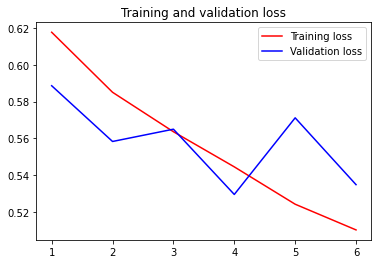

In [39]:
draw(history1)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 128
EPOCH = 100
DROPOUT = 0.5

def create_model_1():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(CuDNNLSTM(units = 64, input_shape=(TIME_STEP, INPUT_DIM), return_sequences = True))
  model.add(Dropout(DROPOUT))
  model.add(CuDNNLSTM(units = 32))
  model.add(Dropout(DROPOUT))

  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10, 64)            9024      
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, 10, 64)            33280     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 54,881
Trainable params: 54,881
Non-trainable params: 0
__________________________________________________

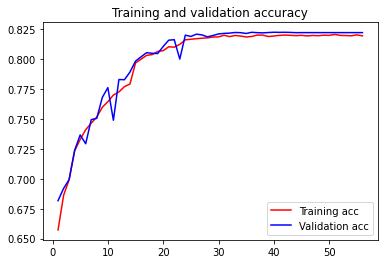

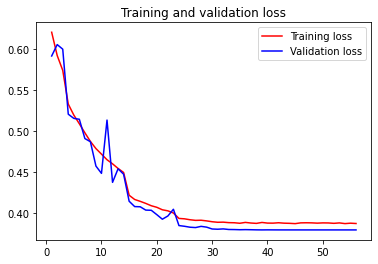

In [41]:
# create model
model1_1 = create_model_1()
history1_1 = model1_1.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score1_1 = model1_1.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score1_1[0], "test acc: ", score1_1[1])
draw(history1_1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 10, 64)            9024      
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 10, 64)            33280     
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 32)                12544     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 54,881
Trainable params: 54,881
Non-trainable params: 0
__________________________________________________

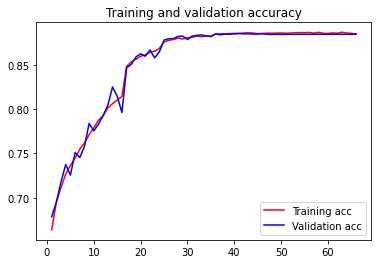

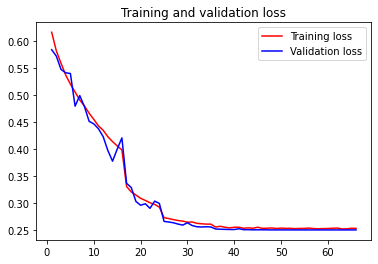

In [42]:
# create model
model1_2 = create_model_1()
history1_2 = model1_2.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score1_2 = model1_2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score1_2[0], "test acc: ", score1_2[1])
draw(history1_2)

In [0]:
# hyperparameter
TIME_STEP = 10
BATCH_SIZE = 64
EPOCH = 100
DROPOUT = 0.5

def create_model_2():
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                   input_shape=(TIME_STEP, INPUT_DIM)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 64)             17984     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                12850     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 30,885
Trainable params: 30,885
Non-trainable params: 0
_________________________________________________________________
Train on 109404 samples, validate on 19307 samples
Epoch 1/100
 - 7s - loss: 0.8931 - acc: 0.6435 - val_loss: 0.609

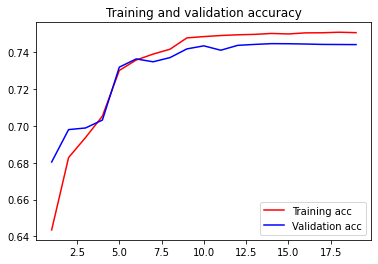

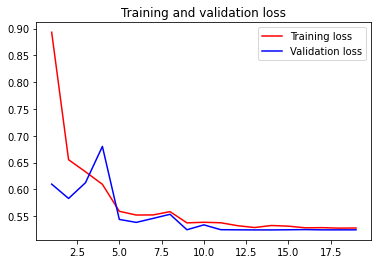

In [44]:
# create model
model2 = create_model_2()
history2 = model2.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score2 = model2.evaluate(X_test, y_test, verbose=2)
print("test loss: ", score2[0], "test acc: ", score2[1])
draw(history2)

In [47]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_model_4():
  model = Sequential()
  model.add(Dense(units = 64, input_shape=(TIME_STEP, INPUT_DIM), activation='relu'))
  model.add(LSTM(64, activation='relu', input_shape=(TIME_STEP, INPUT_DIM), 
                 return_sequences = True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, activation='relu'))
  model.add(Dropout(0.5)) 
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

model4 = create_model_4()
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.15, verbose=2, callbacks=callbacks_list)
score4 = model4.evaluate(X_test, y_test)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 10, 64)            9024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 54,497
Trainable params: 54,497
Non-trainable params: 0
_________________________________________________

test loss:  0.8891054271570563 test acc:  0.48710501194000244


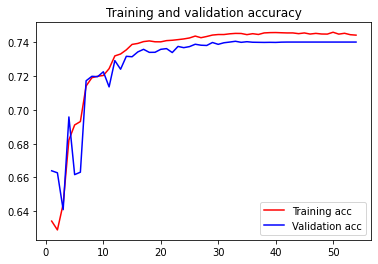

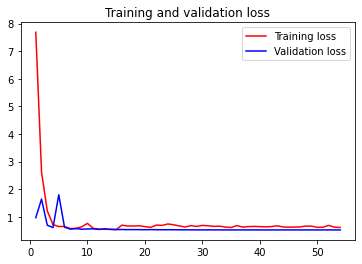

In [48]:
print("test loss: ", score4[0], "test acc: ", score4[1])
draw(history4)

test loss:  56.53916373178726 test acc:  0.5278144478797913


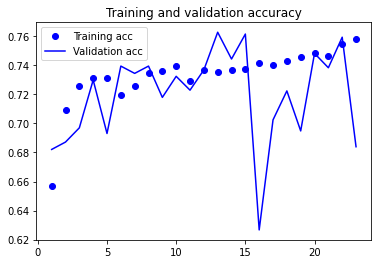

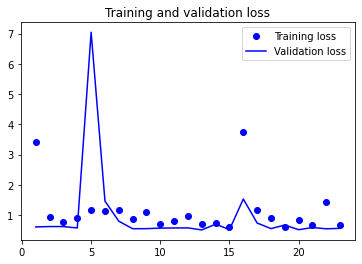

In [0]:
def create_model_5():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(64)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 11s - loss: 0.6120 - acc: 0.6674 - val_loss: 0.5773 - val_acc: 0.7063
Epoch 2/100
 - 11s - loss: 0.5759 - acc: 0.7025 - val_loss: 0.6282 - val_acc: 0.6924
Epoch 3/100
 - 11s - loss: 0.5572 - acc: 0.7164 - val_loss: 0.6154 - val_acc: 0.6580

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
 - 11s - loss: 0.5150 - acc: 0.7415 - val_loss: 0.5076 - val_acc: 0.7492
Epoch 5/100
 - 11s - loss: 0.5040 - acc: 0.7476 - val_loss: 0.4904 - val_acc: 0.7533
Epoch 6/100
 - 11s - loss: 0.4931 - acc: 0.7525 - val_loss: 0.4750 - val_acc: 0.7586
Epoch 7/100
 - 10s - loss: 0.4822 - acc: 0.7591 - val_loss: 0.4647 - val_acc: 0.7646
Epoch 8/100
 - 11s - loss: 0.4715 - acc: 0.7650 - val_loss: 0.4873 - val_acc: 0.7558
Epoch 9/100
 - 11s - loss: 0.4599 - acc: 0.7750 - val_loss: 0.4636 - val_acc: 0.7653
Epoch 10/100
 - 11s - loss: 0.4497 - acc: 0.7824 - val_loss: 0.4335 - val_acc: 0.7908
Epoch 11/100
 - 

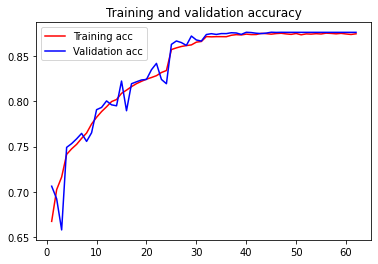

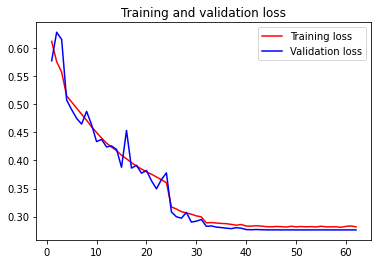

In [50]:
model5 = create_model_5()
history5 = model5.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5 = model5.evaluate(X_test, y_test, verbose=2)
model5.summary()
print(score5)
draw(history5)

In [0]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
score5

[1.3158131882925275, 0.6402605175971985]

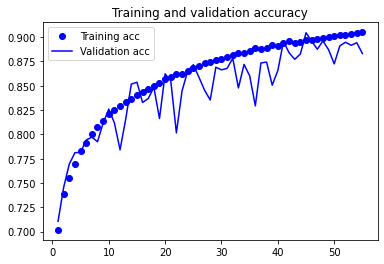

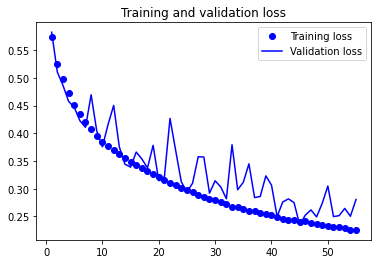

In [0]:
draw(history5)

In [0]:
def create_model5_1():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(128)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 11s - loss: 0.6132 - acc: 0.6635 - val_loss: 0.5765 - val_acc: 0.6948
Epoch 2/100
 - 10s - loss: 0.5748 - acc: 0.7039 - val_loss: 0.5839 - val_acc: 0.6899
Epoch 3/100
 - 11s - loss: 0.5467 - acc: 0.7246 - val_loss: 0.5387 - val_acc: 0.7298
Epoch 4/100
 - 11s - loss: 0.5262 - acc: 0.7361 - val_loss: 0.4991 - val_acc: 0.7526
Epoch 5/100
 - 10s - loss: 0.5059 - acc: 0.7491 - val_loss: 0.5047 - val_acc: 0.7514
Epoch 6/100
 - 11s - loss: 0.4897 - acc: 0.7587 - val_loss: 0.5659 - val_acc: 0.7115

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/100
 - 11s - loss: 0.4189 - acc: 0.7992 - val_loss: 0.4140 - val_acc: 0.8015
Epoch 8/100
 - 11s - loss: 0.4020 - acc: 0.8095 - val_loss: 0.4059 - val_acc: 0.8062
Epoch 9/100
 - 11s - loss: 0.3920 - acc: 0.8167 - val_loss: 0.4044 - val_acc: 0.8032
Epoch 10/100
 - 11s - loss: 0.3825 - acc: 0.8217 - val_loss: 0.4047 - val_acc: 0.8151
Epoch 11/100
 - 

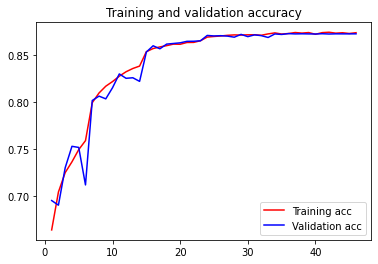

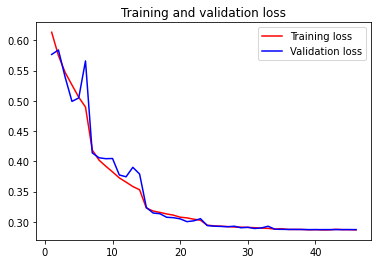

In [52]:
model5_1 = create_model5_1()
history5_1 = model5_1.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_1 = model5_1.evaluate(X_test, y_test, verbose=2)
print(score5_1)
draw(history5_1)

In [0]:
def create_model5_2():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(32)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 16s - loss: 0.6137 - acc: 0.6648 - val_loss: 0.6053 - val_acc: 0.6825
Epoch 2/100
 - 16s - loss: 0.5768 - acc: 0.7013 - val_loss: 0.5487 - val_acc: 0.7200
Epoch 3/100
 - 16s - loss: 0.5556 - acc: 0.7189 - val_loss: 0.5373 - val_acc: 0.7232
Epoch 4/100
 - 16s - loss: 0.5329 - acc: 0.7317 - val_loss: 0.4985 - val_acc: 0.7536
Epoch 5/100
 - 16s - loss: 0.5127 - acc: 0.7475 - val_loss: 0.5248 - val_acc: 0.7310
Epoch 6/100
 - 16s - loss: 0.4948 - acc: 0.7570 - val_loss: 0.4723 - val_acc: 0.7744
Epoch 7/100
 - 16s - loss: 0.4783 - acc: 0.7694 - val_loss: 0.4805 - val_acc: 0.7684
Epoch 8/100
 - 16s - loss: 0.4672 - acc: 0.7743 - val_loss: 0.5209 - val_acc: 0.7360

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 9/100
 - 16s - loss: 0.4033 - acc: 0.8096 - val_loss: 0.3797 - val_acc: 0.8240
Epoch 10/100
 - 16s - loss: 0.3903 - acc: 0.8176 - val_loss: 0.3734 - val_acc: 0.8283
Epoch 11/100
 - 

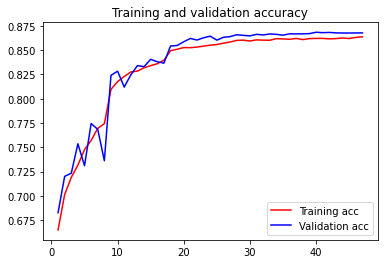

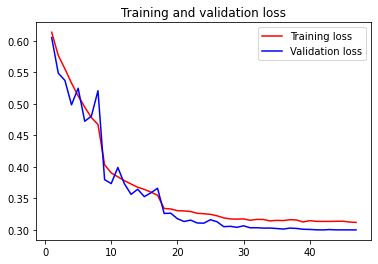

In [59]:
model5_2 = create_model5_2()
history5_2 = model5_2.fit(X_train, y_train, epochs=100, batch_size=50, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_2 = model5_2.evaluate(X_test, y_test, verbose=2)
print(score5_2)
draw(history5_2)

In [0]:
def create_model5_2():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(32)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 17s - loss: 0.6104 - acc: 0.6698 - val_loss: 0.5940 - val_acc: 0.6799
Epoch 2/100
 - 16s - loss: 0.5766 - acc: 0.7041 - val_loss: 0.5812 - val_acc: 0.6961
Epoch 3/100
 - 16s - loss: 0.5513 - acc: 0.7213 - val_loss: 0.5286 - val_acc: 0.7283
Epoch 4/100
 - 16s - loss: 0.5281 - acc: 0.7370 - val_loss: 0.5145 - val_acc: 0.7397
Epoch 5/100
 - 16s - loss: 0.5050 - acc: 0.7515 - val_loss: 0.4876 - val_acc: 0.7641
Epoch 6/100
 - 16s - loss: 0.4862 - acc: 0.7638 - val_loss: 0.4608 - val_acc: 0.7790
Epoch 7/100
 - 16s - loss: 0.4710 - acc: 0.7738 - val_loss: 0.4902 - val_acc: 0.7662
Epoch 8/100
 - 16s - loss: 0.4577 - acc: 0.7811 - val_loss: 0.4667 - val_acc: 0.7743
Epoch 9/100
 - 16s - loss: 0.4476 - acc: 0.7892 - val_loss: 0.4307 - val_acc: 0.8001
Epoch 10/100
 - 15s - loss: 0.4392 - acc: 0.7941 - val_loss: 0.4597 - val_acc: 0.7679
Epoch 11/100
 - 16s - loss: 0.4296 - acc: 0.7980 - val_loss: 0.4124 - val_acc: 0.8026
Epoch 12/100

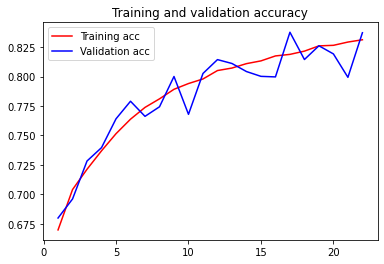

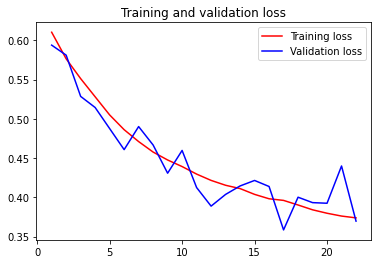

In [62]:
model5_3 = create_model5_2()
history5_3 = model5_3.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_3 = model5_3.evaluate(X_test, y_test, verbose=2)
print(score5_3)
draw(history5_3)

In [0]:
def create_model5_3():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(32)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 10s - loss: 0.6173 - acc: 0.6614 - val_loss: 0.6222 - val_acc: 0.6438
Epoch 2/100
 - 8s - loss: 0.5834 - acc: 0.6961 - val_loss: 0.5786 - val_acc: 0.6864
Epoch 3/100
 - 8s - loss: 0.5617 - acc: 0.7121 - val_loss: 0.5991 - val_acc: 0.7158
Epoch 4/100
 - 8s - loss: 0.5390 - acc: 0.7276 - val_loss: 0.5505 - val_acc: 0.7163
Epoch 5/100
 - 8s - loss: 0.5212 - acc: 0.7404 - val_loss: 0.7035 - val_acc: 0.7064
Epoch 6/100
 - 8s - loss: 0.5050 - acc: 0.7527 - val_loss: 0.5422 - val_acc: 0.7333
Epoch 7/100
 - 9s - loss: 0.4868 - acc: 0.7628 - val_loss: 0.4846 - val_acc: 0.7527
Epoch 8/100
 - 9s - loss: 0.4720 - acc: 0.7725 - val_loss: 0.5668 - val_acc: 0.7235
Epoch 9/100
 - 9s - loss: 0.4591 - acc: 0.7786 - val_loss: 0.4775 - val_acc: 0.7770
Epoch 10/100
 - 9s - loss: 0.4478 - acc: 0.7865 - val_loss: 0.4590 - val_acc: 0.7750
Epoch 11/100
 - 8s - loss: 0.4394 - acc: 0.7914 - val_loss: 0.4414 - val_acc: 0.7933
Epoch 12/100
 - 8s - l

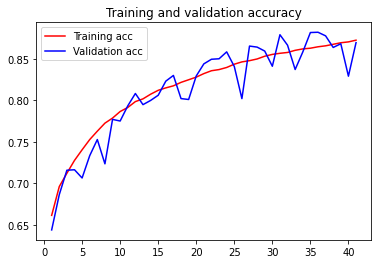

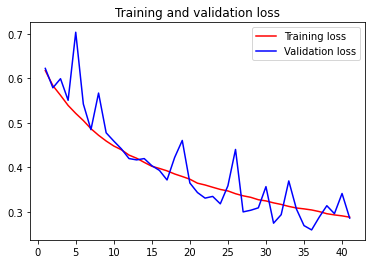

In [66]:
model5_4 = create_model5_3()
history5_4 = model5_4.fit(X_train, y_train, epochs=100, batch_size=128, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_4 = model5_4.evaluate(X_test, y_test, verbose=2)
print(score5_4)
draw(history5_4)

In [0]:
def create_model5_4():
  model = Sequential()
  model.add(Bidirectional(CuDNNLSTM(64, return_sequences = True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(CuDNNLSTM(32)))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
  return model

Train on 102968 samples, validate on 25743 samples
Epoch 1/100
 - 8s - loss: 0.6191 - acc: 0.6580 - val_loss: 0.5953 - val_acc: 0.6755
Epoch 2/100
 - 7s - loss: 0.5838 - acc: 0.6944 - val_loss: 0.5711 - val_acc: 0.6917
Epoch 3/100
 - 7s - loss: 0.5621 - acc: 0.7110 - val_loss: 0.5664 - val_acc: 0.7097
Epoch 4/100
 - 7s - loss: 0.5422 - acc: 0.7267 - val_loss: 0.5853 - val_acc: 0.7046
Epoch 5/100
 - 7s - loss: 0.5237 - acc: 0.7395 - val_loss: 0.5682 - val_acc: 0.7025
Epoch 6/100
 - 7s - loss: 0.5075 - acc: 0.7501 - val_loss: 0.4936 - val_acc: 0.7591
Epoch 7/100
 - 6s - loss: 0.4918 - acc: 0.7594 - val_loss: 0.4952 - val_acc: 0.7519
Epoch 8/100
 - 7s - loss: 0.4802 - acc: 0.7680 - val_loss: 0.4633 - val_acc: 0.7795
Epoch 9/100
 - 6s - loss: 0.4685 - acc: 0.7741 - val_loss: 0.4893 - val_acc: 0.7675
Epoch 10/100
 - 6s - loss: 0.4591 - acc: 0.7794 - val_loss: 0.4468 - val_acc: 0.7876
Epoch 11/100
 - 6s - loss: 0.4506 - acc: 0.7855 - val_loss: 0.4154 - val_acc: 0.8095
Epoch 12/100
 - 6s - lo

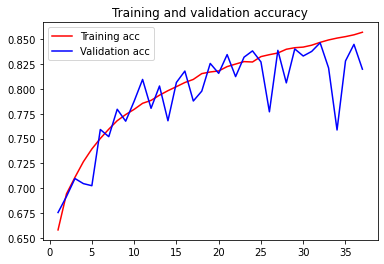

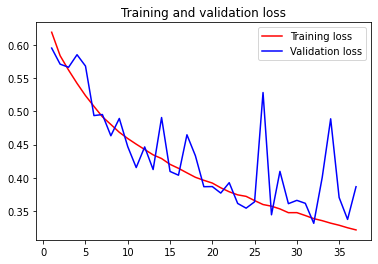

In [68]:
model5_4 = create_model5_2()
history5_4 = model5_4.fit(X_train, y_train, epochs=100, batch_size=128, 
                    validation_split=0.2, verbose=2, callbacks=callbacks_list)
score5_4 = model5_4.evaluate(X_test, y_test, verbose=2)
print(score5_4)
draw(history5_4)